logistic regeression


=== CPU Anomaly Detection ===
[LightGBM] [Info] Number of positive: 11459, number of negative: 11459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 22918, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

RandomForest Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2737
           1       0.72      0.82      0.76       263

    accuracy                           0.96      3000
   macro avg       0.85      0.89      0.87      3000
weighted avg       0.96      0.96      0.96      3000

Optimal Threshold: 0.76
F1-Score: 0.764

LightGBM Performance:
              precision    recall  f1-score   suppo

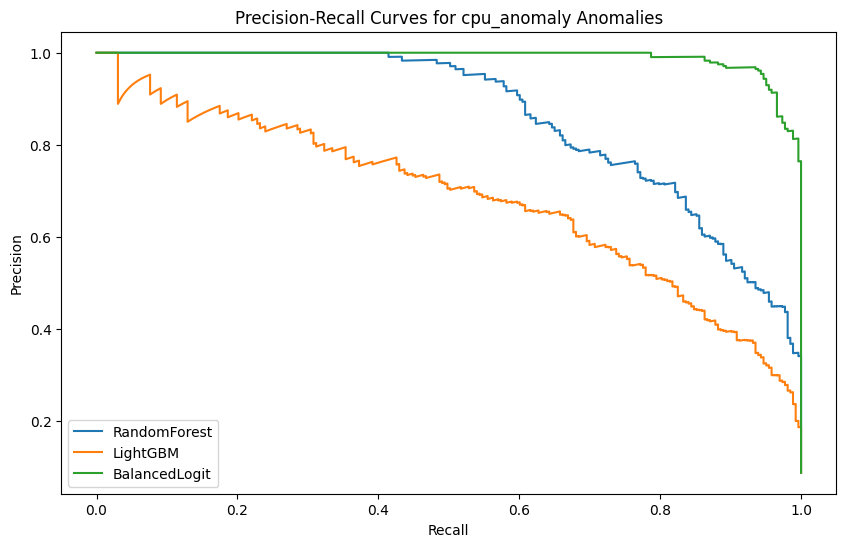


=== Memory Anomaly Detection ===
[LightGBM] [Info] Number of positive: 11447, number of negative: 11447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 22894, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

RandomForest Performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2926
           1       0.46      0.62      0.53        74

    accuracy                           0.97      3000
   macro avg       0.72      0.80      0.76      3000
weighted avg       0.98      0.97      0.97      3000

Optimal Threshold: 0.87
F1-Score: 0.526

LightGBM Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2926
  

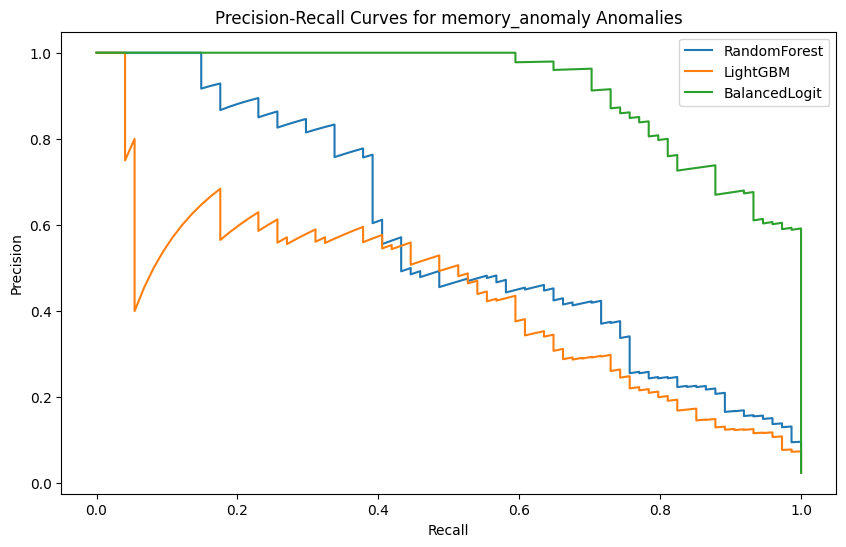

In [6]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# --- Load Data & Feature Engineering ---
df = pd.read_csv("kubernetes_resource_allocation_dataset.csv")

# Add derived features for both CPU and memory
df['cpu_utilization'] = df['cpu_usage'] / df['cpu_limit']
df['memory_utilization'] = df['memory_usage'] / df['memory_limit']
df['cpu_request_diff'] = df['cpu_usage'] - df['cpu_request']
df['memory_request_diff'] = df['memory_usage'] - df['memory_request']

features = [
    'cpu_usage', 'memory_usage', 'cpu_utilization', 'memory_utilization',
    'cpu_request_diff', 'memory_request_diff', 'restart_count', 
    'cpu_limit', 'memory_limit'
]

# --- Add Real-World Noise ---
np.random.seed(42)
noise_factor = 0.1
for col in ['cpu_usage', 'memory_usage']:
    df[col] = df[col] * (1 + noise_factor * np.random.randn(len(df)))

# --- Time-Based Processing ---
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# Rolling features for both resources
window_size = 7
for df_split in [train_df, test_df]:
    # CPU features
    df_split['cpu_ma'] = df_split['cpu_usage'].rolling(window_size).mean()
    df_split['cpu_std'] = df_split['cpu_usage'].rolling(window_size).std()
    
    # Memory features
    df_split['memory_ma'] = df_split['memory_usage'].rolling(window_size).mean()
    df_split['memory_std'] = df_split['memory_usage'].rolling(window_size).std()

# Use last training window stats for test data
test_df['cpu_ma'] = train_df['cpu_ma'].iloc[-window_size:].mean()
test_df['cpu_std'] = train_df['cpu_std'].iloc[-window_size:].mean()
test_df['memory_ma'] = train_df['memory_ma'].iloc[-window_size:].mean()
test_df['memory_std'] = train_df['memory_std'].iloc[-window_size:].mean()

# Anomaly detection logic for both resources
train_df['cpu_anomaly'] = (train_df['cpu_usage'] > (train_df['cpu_ma'] + 1.5 * train_df['cpu_std'])).astype(int)
train_df['memory_anomaly'] = (train_df['memory_usage'] > (train_df['memory_ma'] + 1.5 * train_df['memory_std'])).astype(int)

test_df['cpu_anomaly'] = (test_df['cpu_usage'] > (test_df['cpu_ma'] + 1.5 * test_df['cpu_std'])).astype(int)
test_df['memory_anomaly'] = (test_df['memory_usage'] > (test_df['memory_ma'] + 1.5 * test_df['memory_std'])).astype(int)

# --- Data Preparation ---
train_df = train_df.dropna()
test_df = test_df.dropna()

# --- Import Libraries ---
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# --- Updated Model Training Function ---
def train_and_evaluate(target):
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[target]
    y_test = test_df[target]

    # Feature Scaling & Resampling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Updated model configuration
    models = {
        'RandomForest': RandomForestClassifier(
            class_weight='balanced',
            n_estimators=300,
            max_depth=10
        ),
        'LightGBM': LGBMClassifier(
            class_weight='balanced',
            n_estimators=500,
            learning_rate=0.05
        ),
        'BalancedLogit': LogisticRegression(
            class_weight='balanced',
            solver='saga',
            max_iter=1000
        )
    }

    # Train and evaluate models
    results = {}
    for name, model in models.items():
        model.fit(X_resampled, y_resampled)
        probs = model.predict_proba(X_test_scaled)[:, 1]
        
        # Find optimal threshold
        precision, recall, thresholds = precision_recall_curve(y_test, probs)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresholds[np.argmax(f1_scores)]
        
        # Store results with probabilities
        results[name] = {
            'report': classification_report(y_test, (probs > best_threshold).astype(int)),
            'f1': f1_score(y_test, (probs > best_threshold).astype(int)),
            'threshold': best_threshold,
            'probs': probs  # Store probabilities for visualization
        }
    
    return results

# --- Updated Visualization ---
def plot_pr_curves(results, target_name):
    plt.figure(figsize=(10, 6))
    for model in results:
        probs = results[model]['probs']
        precision, recall, _ = precision_recall_curve(test_df[target_name], probs)
        plt.plot(recall, precision, label=model)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for {target_name} Anomalies')
    plt.legend()
    plt.show()

# --- Train and Evaluate ---
print("=== CPU Anomaly Detection ===")
cpu_results = train_and_evaluate('cpu_anomaly')
for model, result in cpu_results.items():
    print(f"\n{model} Performance:")
    print(result['report'])
    print(f"Optimal Threshold: {result['threshold']:.2f}")
    print(f"F1-Score: {result['f1']:.3f}")
plot_pr_curves(cpu_results, 'cpu_anomaly')

print("\n=== Memory Anomaly Detection ===")
memory_results = train_and_evaluate('memory_anomaly')
for model, result in memory_results.items():
    print(f"\n{model} Performance:")
    print(result['report'])
    print(f"Optimal Threshold: {result['threshold']:.2f}")
    print(f"F1-Score: {result['f1']:.3f}")
plot_pr_curves(memory_results, 'memory_anomaly')

# CNN

Class distribution in y_train (CPU anomalies):
cpu_anomaly
0    11464
1      535
Name: count, dtype: int64

Class distribution in y_train (Memory anomalies):
memory_anomaly
0    11452
1      547
Name: count, dtype: int64

=== CPU Anomaly Detection ===
Unique classes in y_train: [0 1]
Class weights for cpu_anomaly: {0: 0.5233461337057078, 1: 11.208411214953271}
Class weights for cpu_anomaly: {0: 0.5233461337057078, 1: 11.208411214953271}
Cross-Validation F1-Scores for cpu_anomaly: 0.333 (±0.028)

With Optimal Threshold:
With Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2868
           1       0.21      0.53      0.30       125

    accuracy                           0.90      2993
   macro avg       0.60      0.72      0.62      2993
weighted avg       0.95      0.90      0.92      2993

Optimal Threshold: 0.59
F1-Score: 0.303
              precision    recall  f1-score   support

           0       0.98

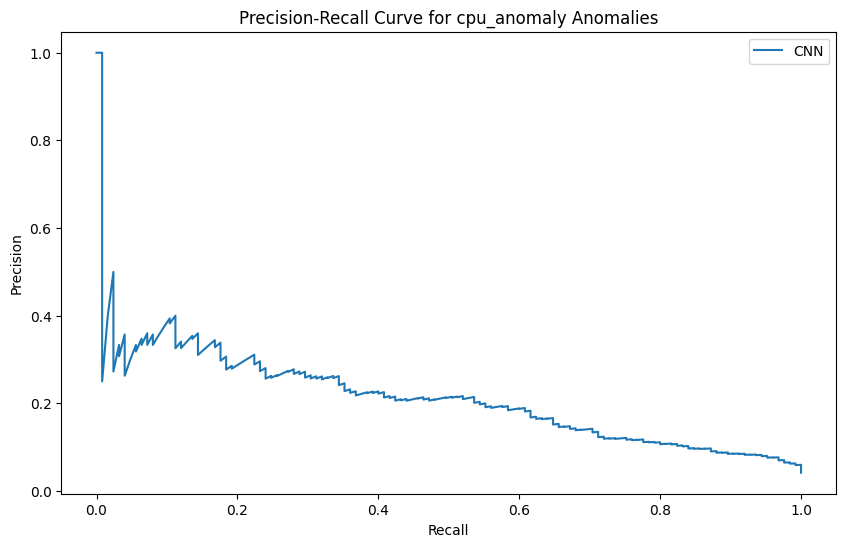


=== Memory Anomaly Detection ===
Unique classes in y_train: [0 1]
Class weights for memory_anomaly: {0: 0.5238948104141185, 1: 10.96252285191956}
Class weights for memory_anomaly: {0: 0.5238948104141185, 1: 10.96252285191956}
Cross-Validation F1-Scores for memory_anomaly: 0.302 (±0.037)

With Optimal Threshold:
With Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.73      0.05      0.09      1492
           1       0.51      0.98      0.67      1501

    accuracy                           0.52      2993
   macro avg       0.62      0.52      0.38      2993
weighted avg       0.62      0.52      0.38      2993

Optimal Threshold: 0.00
F1-Score: 0.671
              precision    recall  f1-score   support

           0       0.53      0.88      0.66      1492
           1       0.64      0.22      0.32      1501

    accuracy                           0.55      2993
   macro avg       0.59      0.55      0.49      2993
weighted avg     

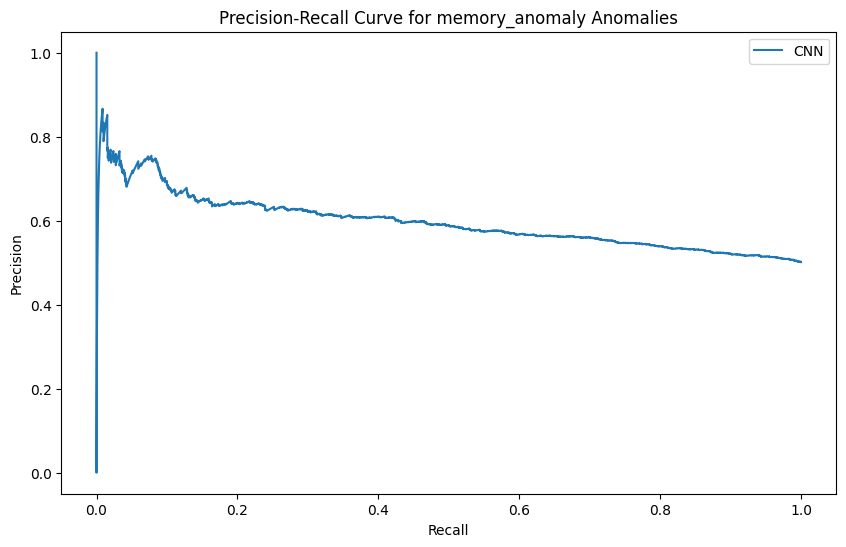

In [7]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# --- Load Data & Feature Engineering ---
df = pd.read_csv("kubernetes_resource_allocation_dataset.csv")

# Add derived features
df['cpu_utilization'] = df['cpu_usage'] / df['cpu_limit']
df['memory_utilization'] = df['memory_usage'] / df['memory_limit']
df['cpu_request_diff'] = df['cpu_usage'] - df['cpu_request']
df['memory_request_diff'] = df['memory_usage'] - df['memory_request']

# Feature list
features = [
    'cpu_usage', 'memory_usage', 'cpu_utilization', 'memory_utilization',
    'cpu_request_diff', 'memory_request_diff', 'restart_count', 
    'cpu_limit', 'memory_limit'
]

# --- Add Real-World Noise ---
np.random.seed(42)
noise_factor = 0.1
for col in ['cpu_usage', 'memory_usage']:
    df[col] = df[col] * (1 + noise_factor * np.random.randn(len(df)))

# --- Time-Based Processing ---
train_size = int(0.8 * len(df))
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# Rolling features (dynamic for train and test)
window_size = 7  # Try 5 or 10 for sensitivity analysis
for df_split in [train_df, test_df]:
    df_split['cpu_ma'] = df_split['cpu_usage'].rolling(window_size, min_periods=1).mean()
    df_split['cpu_std'] = df_split['cpu_usage'].rolling(window_size, min_periods=1).std()
    df_split['memory_ma'] = df_split['memory_usage'].rolling(window_size, min_periods=1).mean()
    df_split['memory_std'] = df_split['memory_usage'].rolling(window_size, min_periods=1).std()

# Anomaly detection with 1.5σ threshold
sigma_threshold = 1.5  # Try 2.0 for stricter anomalies if needed
train_df['cpu_anomaly'] = (train_df['cpu_usage'] > (train_df['cpu_ma'] + sigma_threshold * train_df['cpu_std'])).astype(int)
train_df['memory_anomaly'] = (train_df['memory_usage'] > (train_df['memory_ma'] + sigma_threshold * train_df['memory_std'])).astype(int)

test_df['cpu_anomaly'] = (test_df['cpu_usage'] > (test_df['cpu_ma'] + sigma_threshold * test_df['cpu_std'])).astype(int)
test_df['memory_anomaly'] = (test_df['memory_usage'] > (test_df['memory_ma'] + sigma_threshold * test_df['cpu_std'])).astype(int)  # Fixed typo in original

# --- Data Preparation ---
train_df = train_df.dropna()
test_df = test_df.dropna()

# --- Check Class Distribution ---
print("Class distribution in y_train (CPU anomalies):")
print(train_df['cpu_anomaly'].value_counts())
print("\nClass distribution in y_train (Memory anomalies):")
print(train_df['memory_anomaly'].value_counts())

# --- Function to Create Sliding Windows ---
def create_sliding_windows(data, features, window_size, target_col):
    X, y = [], []
    for i in range(len(data) - window_size + 1):
        X.append(data[features].iloc[i:i+window_size].values)
        y.append(data[target_col].iloc[i+window_size-1])
    return np.array(X), np.array(y)

# --- Model Training Function with Cross-Validation ---
def train_and_evaluate(target, features, train_df, test_df, window_size=7):
    # Prepare data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[features])
    X_test_scaled = scaler.transform(test_df[features])
    
    train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=train_df.index)
    test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=test_df.index)
    train_scaled_df[target] = train_df[target]
    test_scaled_df[target] = test_df[target]

    # Create sliding windows
    X_train, y_train = create_sliding_windows(train_scaled_df, features, window_size, target)
    X_test, y_test = create_sliding_windows(test_scaled_df, features, window_size, target)

    # Calculate class weights
    import numpy as np
    from sklearn.utils.class_weight import compute_class_weight

# Check unique values in y_train
    unique_classes = np.unique(y_train)
    print(f"Unique classes in y_train: {unique_classes}")

# Compute class weights correctly
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
    class_weight_dict = dict(zip(unique_classes, class_weights))

    print(f"Class weights for {target}: {class_weight_dict}")
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    print(f"Class weights for {target}: {class_weight_dict}")

    # Define CNN model
    def build_cnn_model(window_size, num_features):
        model = Sequential([
            Input(shape=(window_size, num_features)),
            Conv1D(64, kernel_size=1, activation='relu'),
            BatchNormalization(),
            Conv1D(128, kernel_size=1, activation='relu'),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Conv1D(256, kernel_size=1, activation='relu'),
            BatchNormalization(),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])
        return model

    # Cross-Validation with early stopping
    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores_cv = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    for train_idx, val_idx in tscv.split(X_train):
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
        
        model_cv = build_cnn_model(window_size, len(features))
        history = model_cv.fit(X_cv_train, y_cv_train, 
                             epochs=20, 
                             batch_size=32, 
                             validation_data=(X_cv_val, y_cv_val),
                             verbose=0,
                             class_weight=class_weight_dict,
                             callbacks=[early_stopping])
        probs_cv = model_cv.predict(X_cv_val, verbose=0).flatten()
        
        precision, recall, thresholds = precision_recall_curve(y_cv_val, probs_cv)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold_cv = thresholds[np.argmax(f1_scores)]
        f1_scores_cv.append(f1_score(y_cv_val, (probs_cv > best_threshold_cv).astype(int)))

    print(f"Cross-Validation F1-Scores for {target}: {np.mean(f1_scores_cv):.3f} (±{np.std(f1_scores_cv):.3f})")

    # Final Model Training with early stopping
    model = build_cnn_model(window_size, len(features))
    history = model.fit(X_train, y_train, 
                       epochs=20, 
                       batch_size=32, 
                       validation_split=0.2,
                       verbose=0,
                       class_weight=class_weight_dict,
                       callbacks=[early_stopping])
    probs = model.predict(X_test, verbose=0).flatten()
    
    # Find optimal threshold and compare with default 0.5
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Results with optimal threshold
    print("\nWith Optimal Threshold:")
    results_optimal = {
        'report': classification_report(y_test, (probs > best_threshold).astype(int)),
        'f1': f1_score(y_test, (probs > best_threshold).astype(int)),
        'threshold': best_threshold,
        'probs': probs
    }
    
    # Results with default threshold (0.5)
    print("With Default Threshold (0.5):")
    results_default = {
        'report': classification_report(y_test, (probs > 0.5).astype(int)),
        'f1': f1_score(y_test, (probs > 0.5).astype(int)),
        'threshold': 0.5,
        'probs': probs
    }
    
    return results_optimal, results_default

# --- Visualization ---
def plot_pr_curves(results, target_name, test_df):
    plt.figure(figsize=(10, 6))
    probs = results['probs']
    precision, recall, _ = precision_recall_curve(test_df[target_name].iloc[window_size-1:], probs)
    plt.plot(recall, precision, label='CNN')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {target_name} Anomalies')
    plt.legend()
    plt.show()

# --- Train and Evaluate ---
print("\n=== CPU Anomaly Detection ===")
cpu_results_optimal, cpu_results_default = train_and_evaluate('cpu_anomaly', features, train_df, test_df)
print(cpu_results_optimal['report'])
print(f"Optimal Threshold: {cpu_results_optimal['threshold']:.2f}")
print(f"F1-Score: {cpu_results_optimal['f1']:.3f}")
print(cpu_results_default['report'])
print(f"Default Threshold F1-Score: {cpu_results_default['f1']:.3f}")
plot_pr_curves(cpu_results_optimal, 'cpu_anomaly', test_df)

print("\n=== Memory Anomaly Detection ===")
memory_results_optimal, memory_results_default = train_and_evaluate('memory_anomaly', features, train_df, test_df)
print(memory_results_optimal['report'])
print(f"Optimal Threshold: {memory_results_optimal['threshold']:.2f}")
print(f"F1-Score: {memory_results_optimal['f1']:.3f}")
print(memory_results_default['report'])
print(f"Default Threshold F1-Score: {memory_results_default['f1']:.3f}")
plot_pr_curves(memory_results_optimal, 'memory_anomaly', test_df)